In [52]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report
from utils import create_param_list, create_train_data_hold_out, create_train_data_CV, inference
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(3407)

In [53]:
Q = 4
nconf = 51
ndata = 400
L = 64
T_cr = 1.135 # critical temp for 2d 4-Clock
t_start = 0.9
exclude_T = (1.07, 1.19)

prm_list, t_end = create_param_list(nconf=nconf, t_start=t_start, L=L, model_name="2d_Clock", q=Q)
print(prm_list)
print(f"データ数:{nconf*ndata}")

[[0.9, '../dataset/2d_Clock/L64_q=4/L64T0_'], [0.91, '../dataset/2d_Clock/L64_q=4/L64T1_'], [0.92, '../dataset/2d_Clock/L64_q=4/L64T2_'], [0.93, '../dataset/2d_Clock/L64_q=4/L64T3_'], [0.94, '../dataset/2d_Clock/L64_q=4/L64T4_'], [0.95, '../dataset/2d_Clock/L64_q=4/L64T5_'], [0.96, '../dataset/2d_Clock/L64_q=4/L64T6_'], [0.97, '../dataset/2d_Clock/L64_q=4/L64T7_'], [0.98, '../dataset/2d_Clock/L64_q=4/L64T8_'], [0.99, '../dataset/2d_Clock/L64_q=4/L64T9_'], [1.0, '../dataset/2d_Clock/L64_q=4/L64T10_'], [1.01, '../dataset/2d_Clock/L64_q=4/L64T11_'], [1.02, '../dataset/2d_Clock/L64_q=4/L64T12_'], [1.03, '../dataset/2d_Clock/L64_q=4/L64T13_'], [1.04, '../dataset/2d_Clock/L64_q=4/L64T14_'], [1.05, '../dataset/2d_Clock/L64_q=4/L64T15_'], [1.06, '../dataset/2d_Clock/L64_q=4/L64T16_'], [1.07, '../dataset/2d_Clock/L64_q=4/L64T17_'], [1.08, '../dataset/2d_Clock/L64_q=4/L64T18_'], [1.09, '../dataset/2d_Clock/L64_q=4/L64T19_'], [1.1, '../dataset/2d_Clock/L64_q=4/L64T20_'], [1.11, '../dataset/2d_Clo

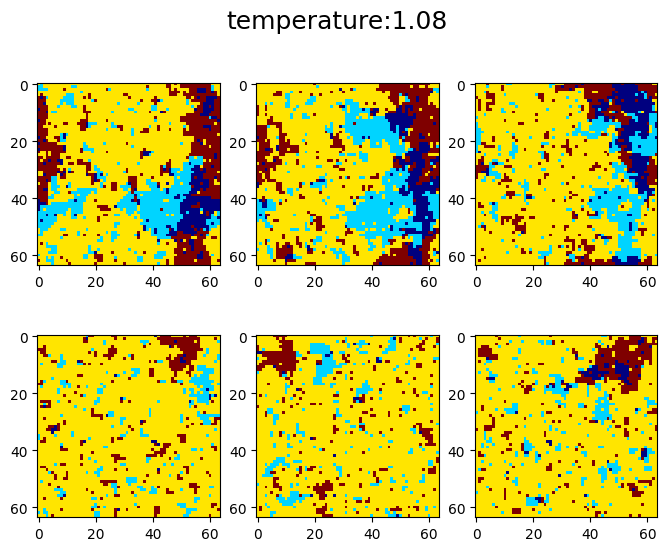

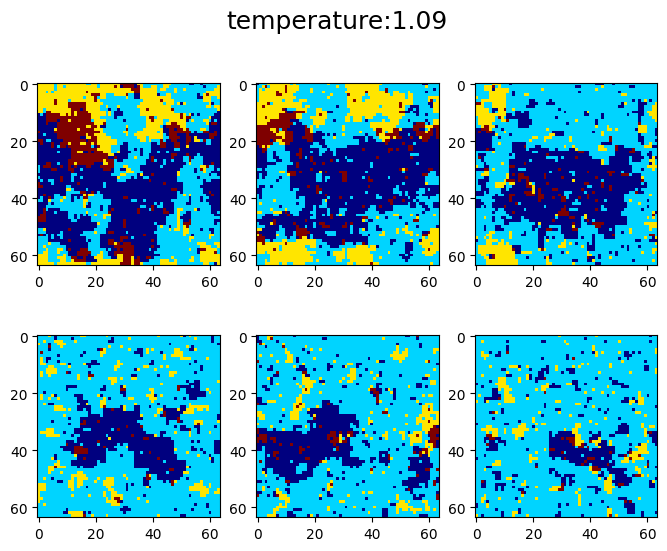

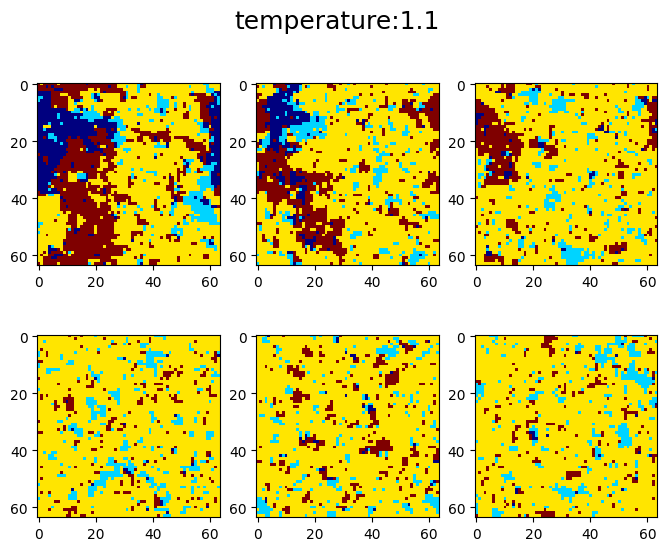

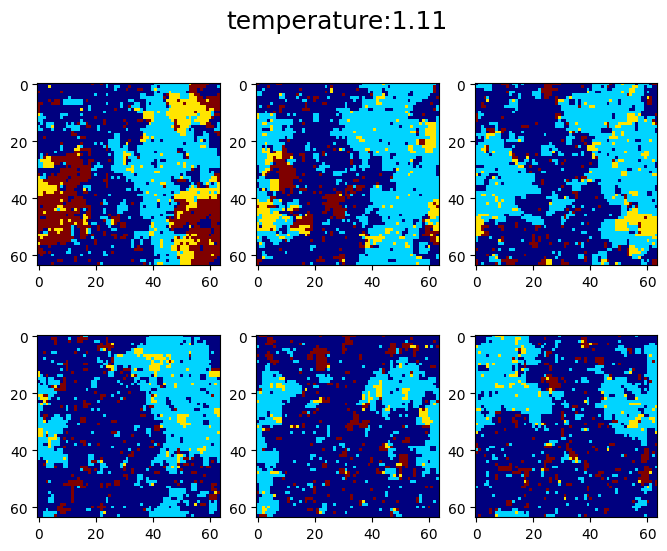

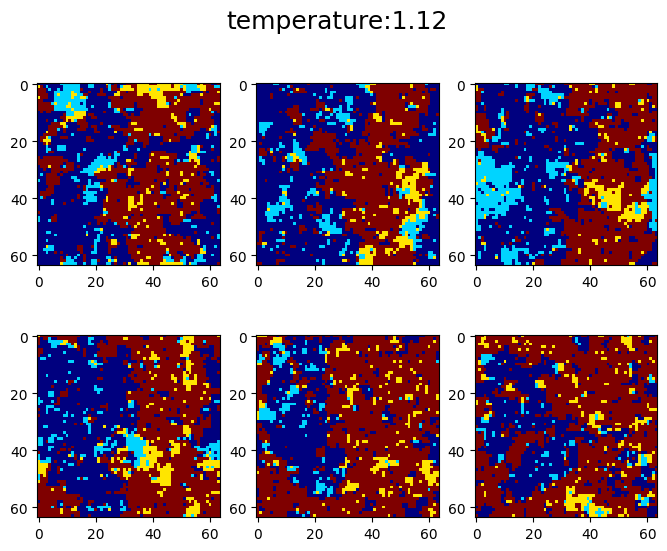

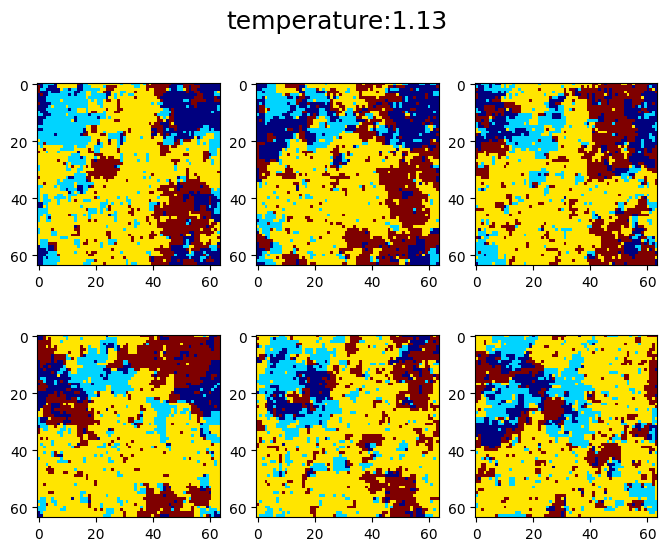

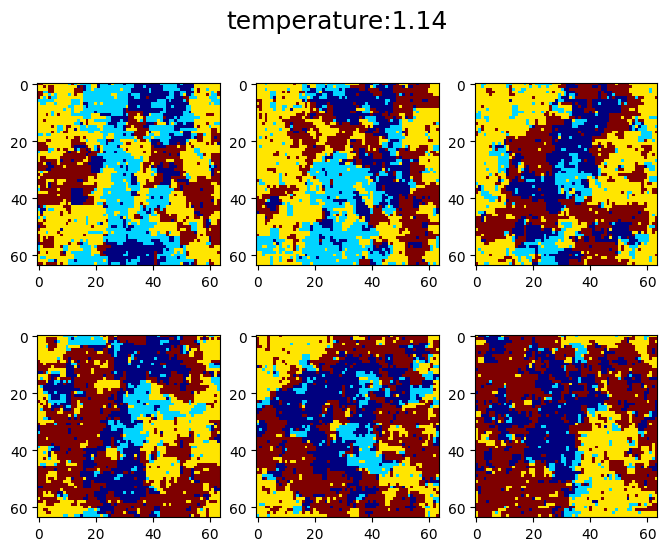

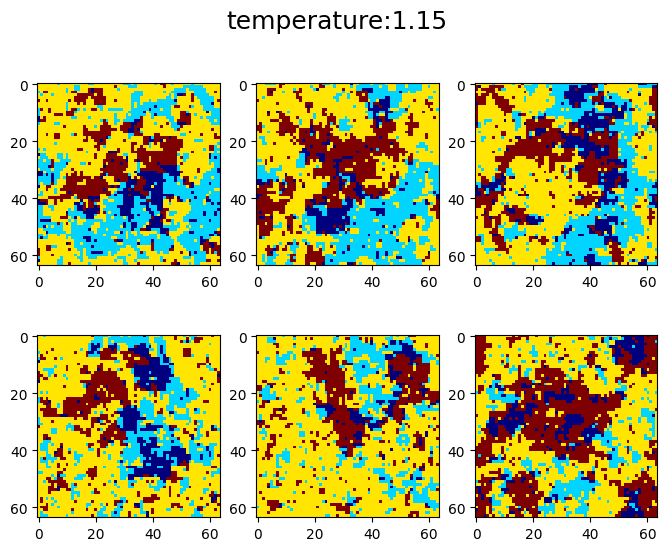

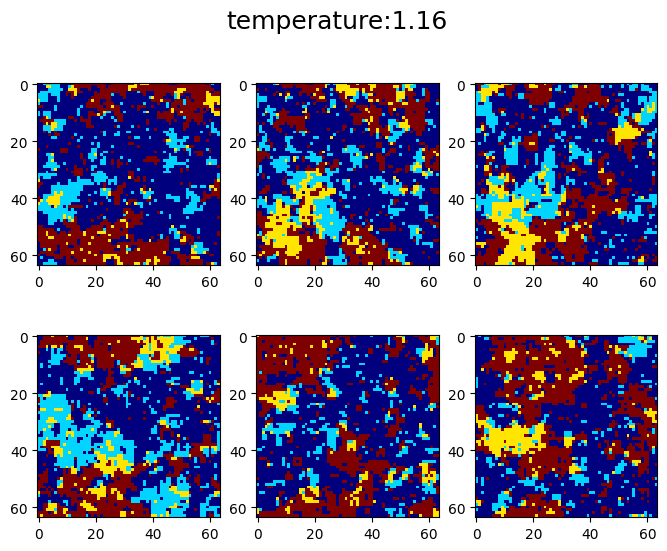

In [54]:
# 可視化
row = 2  # 行数
col = 3  # 列数

for num in range(18, 27):
    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(8, 6))
    fig.suptitle(f"temperature:{prm_list[num][0]}", fontsize=18, color='black')
    for iconf in range(6):
        _r = iconf//col
        _c = iconf % col
        file = f"{prm_list[num][1]}{iconf}.npy"
        sc = np.load(file)
        ax[_r,_c].imshow(sc, interpolation='nearest', vmin=0, vmax=Q-1, cmap='jet')

In [55]:
dataset, _ = create_train_data_CV(
    prm_list,
    ndata, 
    Q=Q,
    T_cr_1=T_cr, 
    exclude_T=exclude_T, 
    total_label=2, 
    split_num=99, 
    normalize=True
)
_, _, test_dataset = create_train_data_hold_out(
    prm_list, 
    ndata, 
    Q=Q,
    T_cr_1=T_cr, 
    exclude_T=exclude_T, 
    total_label=2, 
    split_num=99, 
    normalize=True
)

BATCH_SIZE = 512
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("dataset.shape = ", len(dataset))
print("test_dataset.shape = ", len(test_dataset))

dataset.shape =  15200
test_dataset.shape =  5860


In [40]:
class CNNClassifier(nn.Module):
    def __init__(self, target_size):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 96, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        # self.fc1 = nn.Linear(12*12*96, 64)
        self.fc1 = nn.Linear(14*14*128, 96)
        self.fc2 = nn.Linear(96, 64)
        self.fc3 = nn.Linear(64, target_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        x = self.dropout1(x)
        x = self.relu(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        # x = self.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        # x = self.dropout2(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

mps is available.
FOLD 1
--------------------------------
Epoch: 30, Validation loss: 1.207670684944938e-05, Accuracy: 2757.5491759702286%
Classification Report:
               precision    recall  f1-score   support

           0     0.9993    0.8209    0.9014     50760
           1     0.8722    0.9995    0.9316     62100

    accuracy                         0.9192    112860
   macro avg     0.9358    0.9102    0.9165    112860
weighted avg     0.9294    0.9192    0.9180    112860



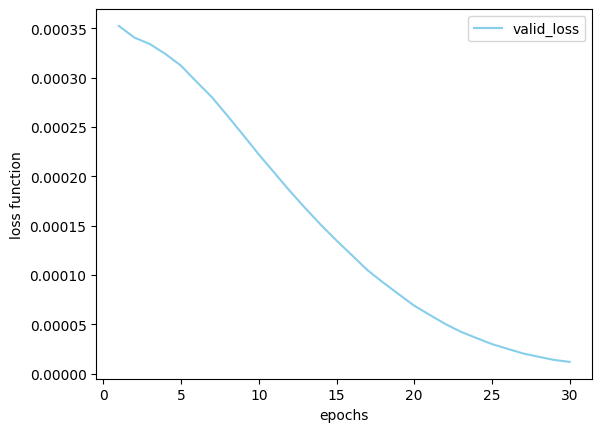

FOLD 2
--------------------------------
Epoch: 30, Validation loss: 7.45117788096707e-06, Accuracy: 2809.941520467836%
Classification Report:
               precision    recall  f1-score   support

           0     0.9959    0.8652    0.9260     51690
           1     0.8975    0.9970    0.9446     61170

    accuracy                         0.9366    112860
   macro avg     0.9467    0.9311    0.9353    112860
weighted avg     0.9426    0.9366    0.9361    112860



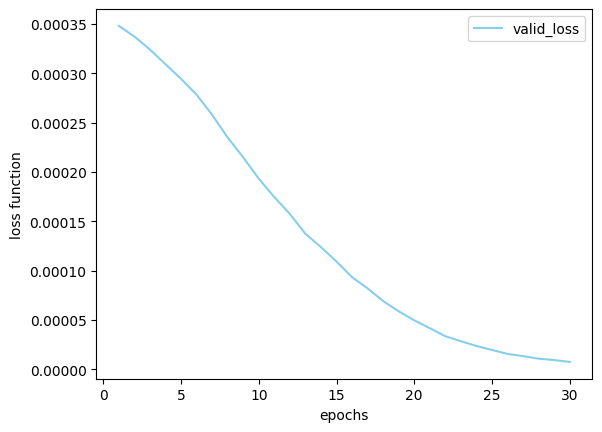

FOLD 3
--------------------------------
Epoch: 30, Validation loss: 3.526100451512844e-06, Accuracy: 2807.3631047315257%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.8574    0.9232     50820
           1     0.8954    1.0000    0.9448     62040

    accuracy                         0.9358    112860
   macro avg     0.9477    0.9287    0.9340    112860
weighted avg     0.9425    0.9358    0.9351    112860



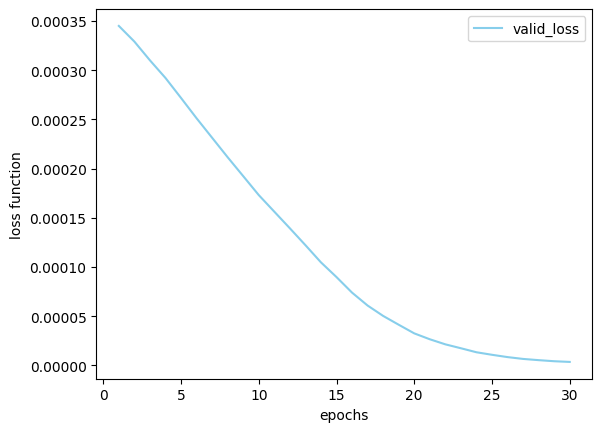

FOLD 4
--------------------------------
Epoch: 30, Validation loss: 4.321318899591218e-06, Accuracy: 2761.6959064327484%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.8192    0.9006     49590
           1     0.8759    1.0000    0.9338     63270

    accuracy                         0.9206    112860
   macro avg     0.9379    0.9096    0.9172    112860
weighted avg     0.9304    0.9206    0.9192    112860



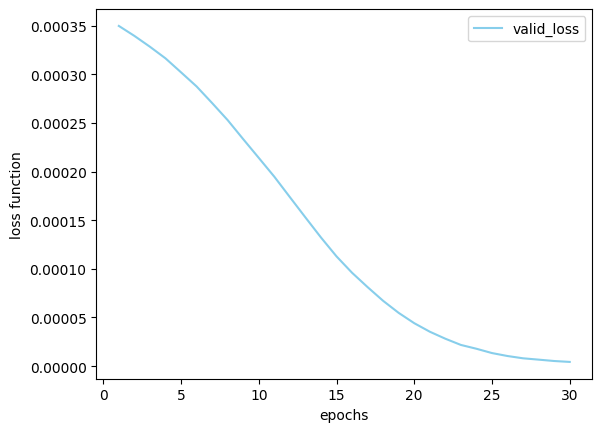

FOLD 5
--------------------------------
Epoch: 30, Validation loss: 7.053048933077602e-06, Accuracy: 2768.8197767145134%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.8261    0.9048     50010
           1     0.8785    1.0000    0.9353     62850

    accuracy                         0.9229    112860
   macro avg     0.9392    0.9130    0.9200    112860
weighted avg     0.9323    0.9229    0.9218    112860



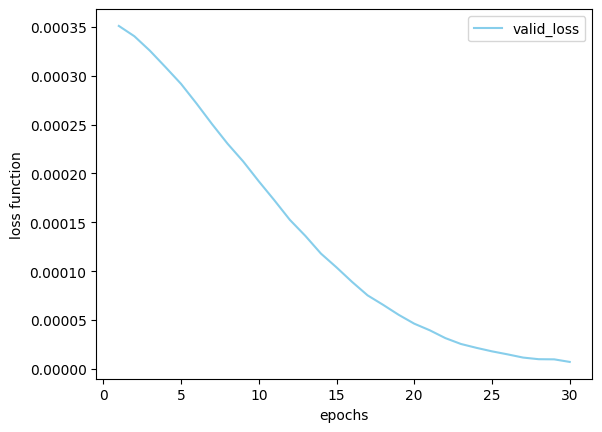

FOLD 6
--------------------------------
Epoch: 30, Validation loss: 1.2882594524689009e-05, Accuracy: 2812.147793726741%
Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.8602    0.9248     50490
           1     0.8983    0.9998    0.9464     62370

    accuracy                         0.9374    112860
   macro avg     0.9491    0.9300    0.9356    112860
weighted avg     0.9437    0.9374    0.9367    112860



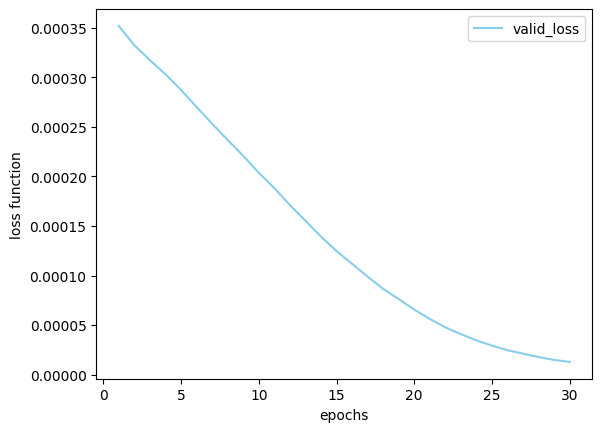

FOLD 7
--------------------------------
Epoch: 30, Validation loss: 1.5878204235182927e-05, Accuracy: 2756.6454013822436%
Classification Report:
               precision    recall  f1-score   support

           0     0.9988    0.8207    0.9010     50790
           1     0.8720    0.9992    0.9313     62070

    accuracy                         0.9189    112860
   macro avg     0.9354    0.9100    0.9162    112860
weighted avg     0.9291    0.9189    0.9177    112860



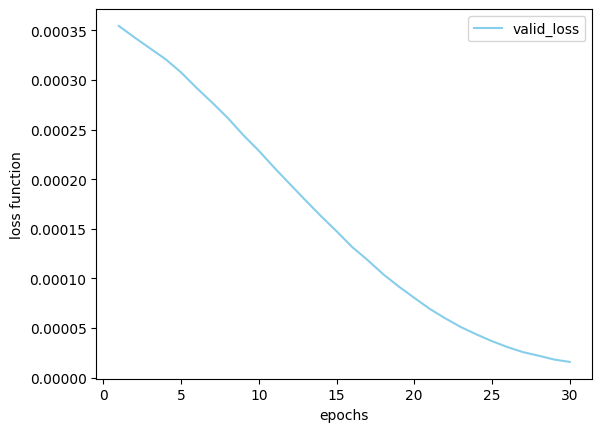

FOLD 8
--------------------------------
Epoch: 30, Validation loss: 8.557631296974993e-06, Accuracy: 2827.3258904837853%
Classification Report:
               precision    recall  f1-score   support

           0     0.9552    0.9137    0.9340     50280
           1     0.9330    0.9655    0.9490     62580

    accuracy                         0.9424    112860
   macro avg     0.9441    0.9396    0.9415    112860
weighted avg     0.9429    0.9424    0.9423    112860



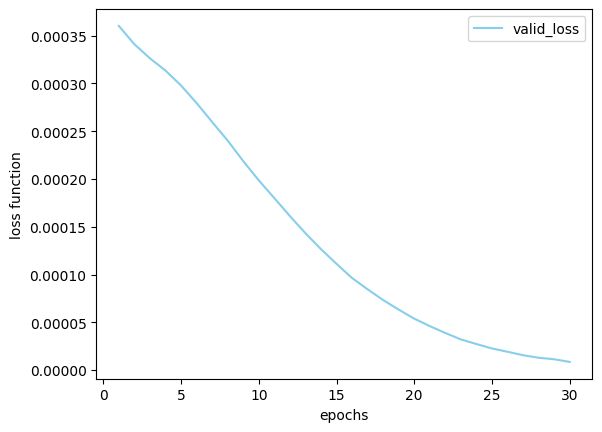

FOLD 9
--------------------------------
Epoch: 30, Validation loss: 6.319357132049954e-06, Accuracy: 2787.692716640085%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.8366    0.9110     48870
           1     0.8890    1.0000    0.9413     63990

    accuracy                         0.9292    112860
   macro avg     0.9445    0.9183    0.9261    112860
weighted avg     0.9371    0.9292    0.9282    112860



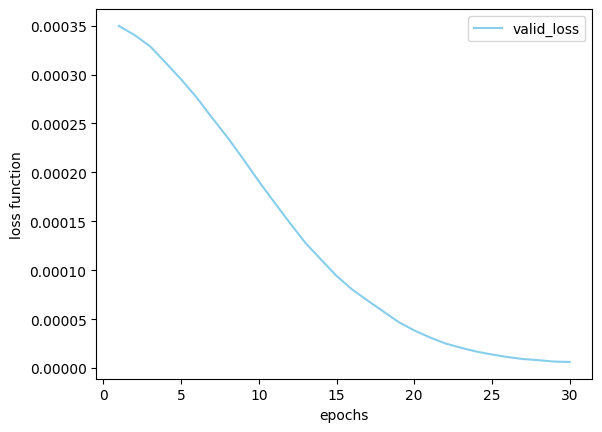

FOLD 10
--------------------------------
Epoch: 30, Validation loss: 1.8297953870247323e-05, Accuracy: 2812.413609782031%
Classification Report:
               precision    recall  f1-score   support

           0     0.9913    0.8709    0.9272     51600
           1     0.9013    0.9936    0.9452     61260

    accuracy                         0.9375    112860
   macro avg     0.9463    0.9322    0.9362    112860
weighted avg     0.9425    0.9375    0.9370    112860



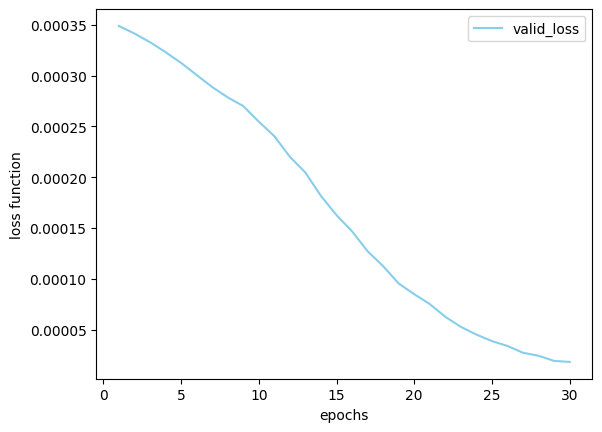

K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
Done.


In [41]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    print("mps is available.")

# hyper parameter
LEARNING_RATE = 0.00001
target_size = 2
grad_clip = 0.1
norm_type = 2
epochs = 30
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

y1s_mean, y2s_mean = np.empty(nconf), np.empty(nconf)
for fold, (train_data, valid_data) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    train_subsampler = SubsetRandomSampler(train_data)
    valid_subsampler = SubsetRandomSampler(valid_data)

    train_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
    valid_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=valid_subsampler)

    model = CNNClassifier(target_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loss_list, vaild_loss_list, accuracy_list = [], [], []
    valid_loss = 0
    correct = 0
    answer, prediction = [], []
    answer_test, prediction_test, temps = [], [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, _, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.type(torch.long))
            train_loss += loss.item()
            loss.backward()
            del loss
            nn.utils.clip_grad_norm_(
                parameters=model.parameters(), max_norm=grad_clip, norm_type=norm_type)
            optimizer.step()
        # train_loss_list.append(train_loss)

        model.eval()
        with torch.no_grad():
            for data, _, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                valid_loss += criterion(output, target.type(torch.long)).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                prediction += list(pred.cpu().numpy())
                answer += list(target.cpu().numpy())

            
            for data, temp, target in test_loader:
                data = data.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=False)
                prediction_test += list(pred.cpu().numpy())
                answer_test += list(target.cpu().numpy())
                temps += list(temp.cpu().numpy())

        valid_loss /= len(valid_loader.sampler.indices)
        accuracy = 100 * correct / len(valid_loader.sampler.indices)

        vaild_loss_list.append(valid_loss)
        accuracy_list.append(accuracy)
        if epoch == epochs - 1:
            print(f'Epoch: {epoch+1}, Validation loss: {valid_loss}, Accuracy: {accuracy}%')
            print("Classification Report:\n", classification_report(answer, prediction, digits=4))
    xs, y1s, y2s = inference(len(test_dataset), temps, prediction_test, target_size)
    y1s_mean += y1s
    y2s_mean += y2s
    plt.xlabel('epochs')
    plt.ylabel('loss function')
    # plt.plot(np.arange(1, epochs+1), train_loss_list, label="train_loss", color="orange")
    plt.plot(np.arange(1, epochs+1), vaild_loss_list,
             label="valid_loss", color="skyblue")
    plt.legend()
    plt.show()
y1s_mean /= k_folds
y2s_mean /= k_folds
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print("Done.")
torch.save(model, "2d_Clock_q=4_model_classifier.pth")

In [44]:
torch.save(model, "../models/2d_Clock_q=4_model_classifier.pth")

In [50]:
model = torch.load("../models/2d_Clock_q=4_model_classifier.pth")

y1s_mean, y2s_mean = np.empty(nconf), np.empty(nconf)
niter = 100
model.eval()
for iter in range(niter):
    answer_test, prediction_test, temps = [], [], []
    for data, temp, target in test_loader:
        data = data.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=False)
        prediction_test += list(pred.cpu().numpy())
        answer_test += list(target.cpu().numpy())
        temps += list(temp.cpu().numpy())
    xs, y1s, y2s = inference(len(test_dataset), temps, prediction_test, target_size)
    y1s_mean += y1s
    y2s_mean += y2s
y1s_mean /= niter
y2s_mean /= niter

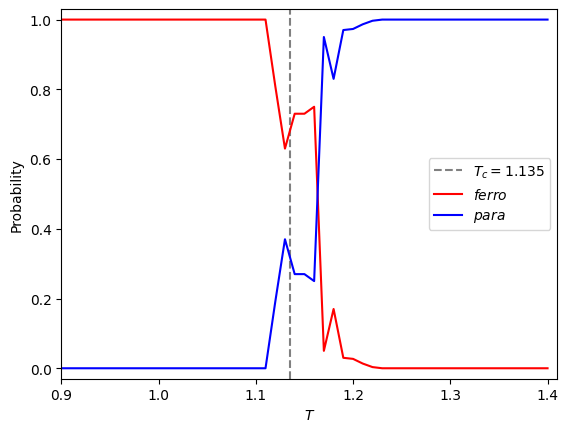

In [56]:
plt.axvline(x=T_cr, ymin=0, ymax=1, ls="dashed",
            color="gray", label=r"$T_c={}$".format(T_cr))
plt.xlim(t_start, t_end)
plt.ylim(-0.03, 1.03)
plt.plot(xs, y1s_mean, label=r"$ferro$", color="red")
plt.plot(xs, y2s_mean, label=r"$para$", color="blue")
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel(r"Probability")
plt.show()